### 인디언 신체 정보 불러오기

In [1]:
import pandas as pd

PIMA_url = 'https://raw.githubusercontent.com/PinkWink/ML_tutorial/master/dataset/diabetes.csv'

PIMA = pd.read_csv(PIMA_url)
PIMA.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### 전부 실수형으로 변환

In [3]:
PIMA = PIMA.astype('float')
PIMA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    float64
 1   Glucose                   768 non-null    float64
 2   BloodPressure             768 non-null    float64
 3   SkinThickness             768 non-null    float64
 4   Insulin                   768 non-null    float64
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    float64
 8   Outcome                   768 non-null    float64
dtypes: float64(9)
memory usage: 54.1 KB


### 상관관계 확인

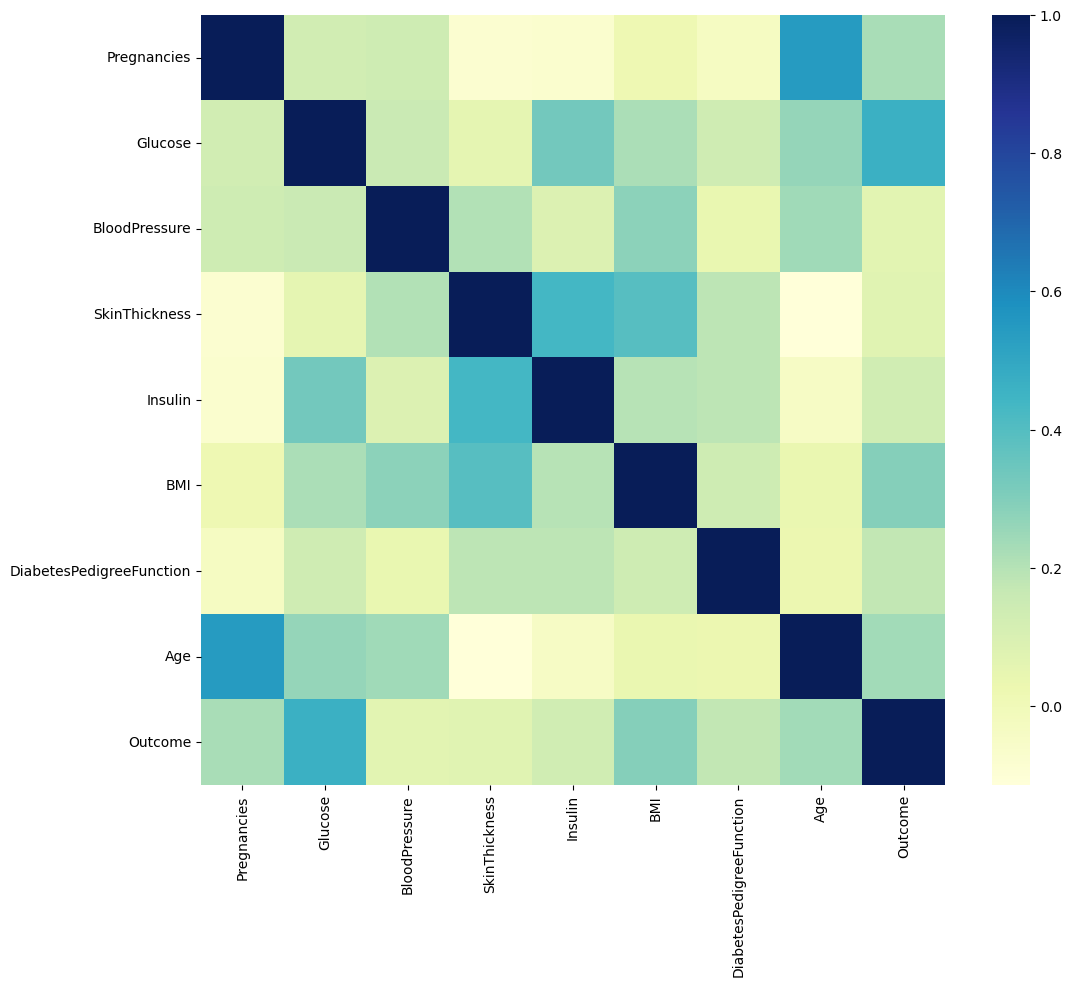

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12,10))
sns.heatmap(PIMA.corr(), cmap='YlGnBu')
plt.show()

- outcome과 연관있는 4개의 특성....무엇일까
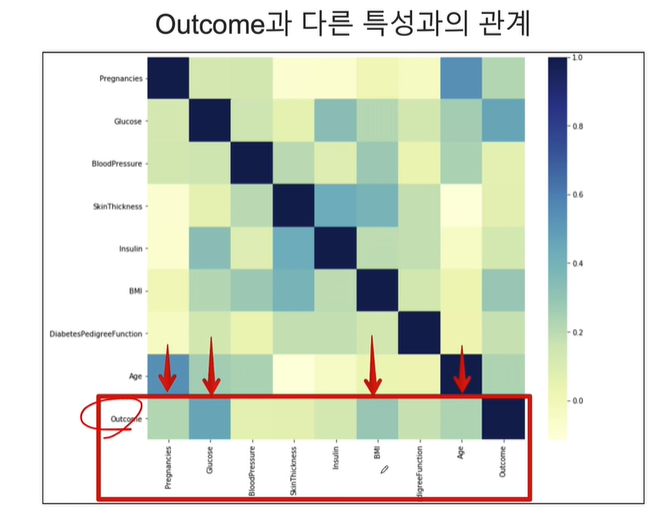

### 0이 있는지 확인(아주유용한 방법, EDA에서 매우 중요한 작업)

In [5]:
(PIMA==0).astype(int).sum()

Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64

- BloodPressure : 혈압
    - 혈압이 0인건 잘못된 데이터!
    - 0인 데이터들을 그 데이터의 평균으로 일단 대체하자

In [6]:
zero_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'BMI']
PIMA[zero_features] = PIMA[zero_features].replace(0,PIMA[zero_features].mean())
(PIMA==0).astype(int).sum()

Pregnancies                 111
Glucose                       0
BloodPressure                 0
SkinThickness                 0
Insulin                     374
BMI                           0
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64

### 이제 학습하기 위해 데이터를 나누자

In [7]:
from sklearn.model_selection import train_test_split

X = PIMA.drop(['Outcome'], axis=1)
y = PIMA['Outcome']

# stratify는 데이터를 나눌때 테이터의 비율을 유지한채로 나누라는 소리다.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13, stratify=y)

#### 파이프라인 모델

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

estimators = [
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(solver='liblinear', random_state=13))
]

pipe_lr = Pipeline(estimators)
pipe_lr.fit(X_train, y_train)
pred = pipe_lr.predict(X_test)

### 결과 확인

In [14]:
from sklearn.metrics import (accuracy_score, recall_score, precision_score,
                             roc_auc_score, f1_score)

print('Accuracy :', accuracy_score(y_test, pred))
print('Recall :', recall_score(y_test, pred))
print('Precision :', precision_score(y_test, pred))
print('AUC score :', roc_auc_score(y_test, pred))
print('f1 score :', f1_score(y_test, pred))

Accuracy : 0.7727272727272727
Recall : 0.6111111111111112
Precision : 0.7021276595744681
AUC score : 0.7355555555555556
f1 score : 0.6534653465346535


- 그러나 상대적 의미를 가질수 없어서 이 수치 자체를 평가 할 수는 없다?

### 각 독립변수들의 계수 확인
- 여기서는 8개의 특성이 있어 8개가 나온다.

In [20]:
coff = list(pipe_lr['clf'].coef_[0])
labels = list(X_train.columns)

In [21]:
dict(zip(labels, coff))

{'Pregnancies': 0.3542658884412651,
 'Glucose': 1.2014244425037581,
 'BloodPressure': -0.1584013553628671,
 'SkinThickness': 0.03394657712929954,
 'Insulin': -0.16286471953988116,
 'BMI': 0.620404521989511,
 'DiabetesPedigreeFunction': 0.36669355795578745,
 'Age': 0.17195965447035097}

### feature 그래프로 그려보자

In [24]:
features = pd.DataFrame( {'Features' : labels, 'importance' : coff} )

features.sort_values(by=['importance'], ascending=True, inplace=True)
features

,Features,importance
4,Insulin,-0.162865
2,BloodPressure,-0.158401
3,SkinThickness,0.033947
7,Age,0.171960
0,Pregnancies,0.354266
6,DiabetesPedigreeFunction,0.366694
5,BMI,0.620405
1,Glucose,1.201424


In [25]:
features['positive'] = features['importance'] > 0
features

,Features,importance,positive
4,Insulin,-0.162865,False
2,BloodPressure,-0.158401,False
3,SkinThickness,0.033947,True
7,Age,0.171960,True
0,Pregnancies,0.354266,True
6,DiabetesPedigreeFunction,0.366694,True
5,BMI,0.620405,True
1,Glucose,1.201424,True


In [26]:
features.set_index('Features', inplace=True)
features

,importance,positive
Features,,
Insulin,-0.162865,False
BloodPressure,-0.158401,False
SkinThickness,0.033947,True
Age,0.171960,True
Pregnancies,0.354266,True
DiabetesPedigreeFunction,0.366694,True
BMI,0.620405,True
Glucose,1.201424,True


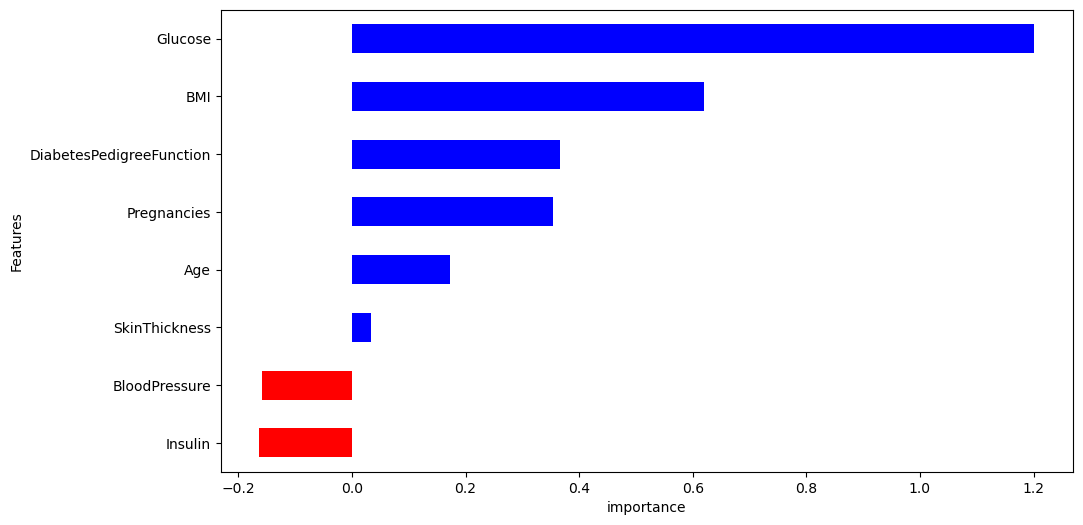

In [27]:
features['importance'].plot(kind='barh',
                            figsize=(11,6),
                            color=features['positive'].map({True:'b',False:'r'})
                           )

plt.xlabel('importance')
plt.show()

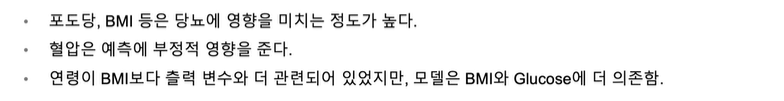